https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces/data

# Import Library

In [ ]:
import os
import csv 
import cv2
import time
import math
import random
import numpy as np
import pandas as pd
import absl.logging
from PIL import Image
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.models import load_model
from keras import layers, Model, optimizers, losses
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import backend as K

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="absl")
tf.get_logger().setLevel('ERROR')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
absl.logging.set_verbosity(absl.logging.ERROR)
SEED = 42
random.seed(SEED)         
np.random.seed(SEED)      
tf.random.set_seed(SEED)  
os.environ['PYTHONHASHSEED'] = str(SEED) 

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

In [2]:
conda_prefix = os.environ.get('CONDA_PREFIX')

cuda_data_dir_conda = conda_prefix
expected_libdevice_path = os.path.join(cuda_data_dir_conda, "nvvm", "libdevice", "libdevice.10.bc")
os.environ['XLA_FLAGS'] = f'--xla_gpu_cuda_data_dir="{cuda_data_dir_conda}"'
os.environ['CUDA_HOME'] = cuda_data_dir_conda # Also set CUDA_HOME
print(f"XLA_FLAGS set to: {os.environ['XLA_FLAGS']}")
print(f"CUDA_HOME set to: {os.environ['CUDA_HOME']}")
print(f"Target libdevice file found at: {expected_libdevice_path}")
   
print(f"TensorFlow Version: {tf.__version__}")

XLA_FLAGS set to: --xla_gpu_cuda_data_dir="C:\Users\Lenovo\.conda\envs\tens"
CUDA_HOME set to: C:\Users\Lenovo\.conda\envs\tens
Target libdevice file found at: C:\Users\Lenovo\.conda\envs\tens\nvvm\libdevice\libdevice.10.bc
TensorFlow Version: 2.10.0


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth set.")
    except RuntimeError as e:
        print(e)

GPU memory growth set.


# Data Preprocessing

Here i created the model on a new folder for clean setup, we still used the same file of real_sampled that used by our DC-GAN model.

# Resized 

Many sources says that vannilla GAN trained better with 64 * 64 images

In [ ]:
input_folder = './real_sampled'
resized_folder = './resized_64x64'

os.makedirs(resized_folder, exist_ok=True)

for filename in os.listdir(input_folder):
    if filename.lower().endswith('.jpg'):
        img_path = os.path.join(input_folder, filename)
        image = cv2.imread(img_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        resized_image = cv2.resize(image_rgb, (64, 64), interpolation=cv2.INTER_AREA)

        save_path = os.path.join(resized_folder, filename)
        cv2.imwrite(save_path, cv2.cvtColor(resized_image, cv2.COLOR_RGB2BGR))

# Normalized

In [5]:
def normalize_image(image):
    """
    Normalize a NumPy image array from [0, 255] to [-1, 1]
    """
    return (image.astype(np.float32) / 127.5) - 1.0

def denormalize_image(image):
    """
    Denormalize a NumPy image array from [-1, 1] back to [0, 255]
    """
    image = ((image + 1.0) * 127.5)
    return np.clip(image, 0, 255).astype(np.uint8)


In [ ]:
normalized_folder = './normalized_arrays'
os.makedirs(normalized_folder, exist_ok=True)

for filename in os.listdir(resized_folder):
    if filename.lower().endswith('.jpg'):
        img_path = os.path.join(resized_folder, filename)
        image = cv2.imread(img_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        normalized_img = normalize_image(image_rgb)

        np.save(os.path.join(normalized_folder, filename.split('.')[0] + '.npy'), normalized_img)

# Data Preparation

## Define the Data Loader

In [ ]:
npy_dir = "./normalized_arrays"

npy_files = [os.path.join(npy_dir, fname) for fname in os.listdir(npy_dir) if fname.endswith('.npy')]

file_dataset = tf.data.Dataset.from_tensor_slices(npy_files)

def load_npy_image(file_path):
    def _load_numpy(path):
        data = np.load(path.decode('utf-8')) 
        return data.astype(np.float32) 

    image = tf.numpy_function(_load_numpy, [file_path], tf.float32)
    image.set_shape([None, None, 3]) 
    return image

## Apply Batch, Shuffle, Prefetch

In [ ]:
dataset = file_dataset.map(load_npy_image, num_parallel_calls=tf.data.AUTOTUNE)

BATCH_SIZE = 32

dataset = dataset.shuffle(buffer_size=1000) \
                 .batch(BATCH_SIZE) \
                 .prefetch(tf.data.AUTOTUNE)

## Example using the data loader

In [ ]:
for image_batch in dataset.take(1):
    print("Sample batch shape:", image_batch.shape)
    print("Sample image min/max:", np.min(image_batch[0]), np.max(image_batch[0]))
    break

Sample batch shape: (32, 64, 64, 3)
Sample image min/max: -1.0 0.9607843


the diffrence now we only use 64 * 64 images

# Modelling

In [ ]:
IMAGE_SIZE = 64 
NUM_CHANNELS = 3
LATENT_DIM = 100

GENERATOR_HIDDEN_UNITS = [256, 512, 1024] 
DISCRIMINATOR_HIDDEN_UNITS = [1024, 512, 256] 

LEARNING_RATE_G = 0.0001
LEARNING_RATE_D = 0.0001 
BETA1 = 0.5
NUM_EPOCHS = 1000 
SAVE_EVERY_ITER = 100 

BATCH_SIZE = 32

SAMPLE_DIR_VANILLA = "gan_tf_vanilla_samples"
CHECKPOINT_DIR_VANILLA = './gan_tf_vanilla_checkpoints'


IMAGE_FLAT_DIM = IMAGE_SIZE * IMAGE_SIZE * NUM_CHANNELS

In [ ]:
def make_vanilla_generator_model(latent_dim=LATENT_DIM, hidden_units=GENERATOR_HIDDEN_UNITS,
                                 output_flat_dim=IMAGE_FLAT_DIM, image_size=IMAGE_SIZE, num_channels=NUM_CHANNELS):
    model = tf.keras.Sequential(name="Vanilla_Generator")
    model.add(layers.Input(shape=(latent_dim,)))

    for units in hidden_units:
        model.add(layers.Dense(units, use_bias=False))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dense(output_flat_dim, activation='tanh'))
    model.add(layers.Reshape((image_size, image_size, num_channels)))
    return model

vanilla_generator_test = make_vanilla_generator_model()
noise = tf.random.normal([1, LATENT_DIM])
generated_image_test = vanilla_generator_test(noise, training=False)
print("Vanilla Generator output shape:", generated_image_test.shape)

def make_vanilla_discriminator_model(input_shape=(IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS),
                                     hidden_units=DISCRIMINATOR_HIDDEN_UNITS):
    model = tf.keras.Sequential(name="Vanilla_Discriminator")
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Flatten())

    for units in hidden_units:
        model.add(layers.Dense(units))
        model.add(layers.LeakyReLU(alpha=0.2))
        model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1, activation='sigmoid'))
    return model

vanilla_discriminator_test = make_vanilla_discriminator_model()
decision_test = vanilla_discriminator_test(generated_image_test, training=False)
print("Vanilla Discriminator output shape:", decision_test.shape)

Vanilla Generator output shape: (1, 64, 64, 3)
Vanilla Discriminator output shape: (1, 1)


In [9]:
def denormalize_tf_image_batch(normalized_batch_minus1_1):
    tensor_float32 = tf.cast(normalized_batch_minus1_1, tf.float32)
    denormalized_batch = (tensor_float32 + 1.0) * 127.5
    clipped_batch = tf.clip_by_value(denormalized_batch, 0.0, 255.0)
    uint8_batch = tf.saturate_cast(clipped_batch, tf.uint8)
    return uint8_batch

In [ ]:
class TF_GAN:
    def __init__(self, image_size, latent_dim, num_channels,
                 generator_fn, discriminator_fn,
                 lr_g, lr_d, beta1,
                 checkpoint_dir, h5_save_sub_dir="h5_models"):

        self.image_size = image_size
        self.latent_dim = latent_dim
        self.num_channels = num_channels

    
    
    
        self.generator = generator_fn(
            latent_dim=self.latent_dim,
            hidden_units=GENERATOR_HIDDEN_UNITS,
            output_flat_dim=IMAGE_FLAT_DIM,    
            image_size=self.image_size,
            num_channels=self.num_channels
        )

    
        self.discriminator = discriminator_fn(
            input_shape=(self.image_size, self.image_size, self.num_channels),
            hidden_units=DISCRIMINATOR_HIDDEN_UNITS
        )

        self.generator_optimizer = optimizers.Adam(learning_rate=lr_g, beta_1=beta1)
        self.discriminator_optimizer = optimizers.Adam(learning_rate=lr_d, beta_1=beta1)
        self.loss_fn = losses.BinaryCrossentropy()
        self.fixed_noise = tf.random.normal([16, self.latent_dim])

        self.checkpoint_dir = checkpoint_dir
        self.h5_save_dir = os.path.join(self.checkpoint_dir, h5_save_sub_dir)
        os.makedirs(self.h5_save_dir, exist_ok=True)

        self.checkpoint = tf.train.Checkpoint(
            step=tf.Variable(0, dtype=tf.int64),
            epoch=tf.Variable(0, dtype=tf.int64),
            generator_optimizer=self.generator_optimizer,
            discriminator_optimizer=self.discriminator_optimizer,
            generator=self.generator,
            discriminator=self.discriminator
        )
        self.manager = tf.train.CheckpointManager(self.checkpoint, self.checkpoint_dir, max_to_keep=3)
        print(f"{self.generator.name} and {self.discriminator.name} GAN initialized.")
        print(f"Checkpoints will be saved in: {self.checkpoint_dir}")
        print(f"H5 models will be saved in: {self.h5_save_dir}")


    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.loss_fn(tf.ones_like(real_output), real_output)
        fake_loss = self.loss_fn(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    def generator_loss(self, fake_output):
        return self.loss_fn(tf.ones_like(fake_output), fake_output)

    @tf.function
    def train_step(self, real_images_batch):
        batch_size = tf.shape(real_images_batch)[0]
        noise = tf.random.normal([batch_size, self.latent_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)
            real_output = self.discriminator(real_images_batch, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        return gen_loss, disc_loss

    def train(self, dataset, num_epochs, sample_dir_base="gan_samples"):
    
        current_gan_type_sample_dir = os.path.join(sample_dir_base, self.generator.name.lower())
        os.makedirs(current_gan_type_sample_dir, exist_ok=True)
        print(f"Generated samples will be saved in: {current_gan_type_sample_dir}")

        os.makedirs(self.checkpoint_dir, exist_ok=True)

        all_G_batch_losses_complete_history = []
        all_D_batch_losses_complete_history = []
        csv_log_path_epoch_averages = os.path.join(current_gan_type_sample_dir, "epoch_average_losses.csv")

        self.checkpoint.restore(self.manager.latest_checkpoint)
        start_epoch = self.checkpoint.epoch.numpy()
        global_iteration_step = self.checkpoint.step.numpy()

        if self.manager.latest_checkpoint:
            print(f"Restored from checkpoint. Resuming from epoch {start_epoch + 1}, iteration {global_iteration_step + 1}")
        
        else:
            print("Initializing from scratch. Starting from epoch 1, iteration 1.")
            start_epoch = 0
            global_iteration_step = 0
            with open(csv_log_path_epoch_averages, 'w', newline='') as csvfile:
                csv_writer = csv.writer(csvfile)
                csv_writer.writerow(['epoch', 'avg_generator_loss', 'avg_discriminator_loss'])

        print("Starting Training Loop...")
        num_batches_per_epoch = tf.data.experimental.cardinality(dataset).numpy()
        if num_batches_per_epoch == tf.data.experimental.UNKNOWN_CARDINALITY or num_batches_per_epoch == tf.data.experimental.INFINITE_CARDINALITY:
            print("Warning: Could not determine number of batches per epoch for Progbar. Progbar might not display total.")
            num_batches_per_epoch = None

        for epoch in range(start_epoch, num_epochs):
            current_epoch_display = epoch + 1
            self.checkpoint.epoch.assign(epoch)
            print(f"\nEpoch {current_epoch_display}/{num_epochs}")
            progbar = tf.keras.utils.Progbar(num_batches_per_epoch, stateful_metrics=['g_loss', 'd_loss'])
            current_epoch_g_losses_for_avg = []
            current_epoch_d_losses_for_avg = []
            current_epoch_all_batch_data_for_csv = []

            for batch_idx, image_batch_normalized in enumerate(dataset):
                global_iteration_step += 1
                self.checkpoint.step.assign(global_iteration_step)
                g_loss_tensor, d_loss_tensor = self.train_step(image_batch_normalized)
                g_loss_np, d_loss_np = g_loss_tensor.numpy(), d_loss_tensor.numpy()

                all_G_batch_losses_complete_history.append(g_loss_np)
                all_D_batch_losses_complete_history.append(d_loss_np)
                current_epoch_g_losses_for_avg.append(g_loss_np)
                current_epoch_d_losses_for_avg.append(d_loss_np)
                current_epoch_all_batch_data_for_csv.append([batch_idx + 1, g_loss_np, d_loss_np])

                progbar.update(batch_idx + 1, values=[('g_loss', g_loss_tensor), ('d_loss', d_loss_tensor)])

            avg_g_loss_epoch = np.mean(current_epoch_g_losses_for_avg) if current_epoch_g_losses_for_avg else -1.0
            avg_d_loss_epoch = np.mean(current_epoch_d_losses_for_avg) if current_epoch_d_losses_for_avg else -1.0
            print(f"Epoch {current_epoch_display} Summary: Avg G_Loss: {avg_g_loss_epoch:.4f}, Avg D_Loss: {avg_d_loss_epoch:.4f}")

            self.generate_samples(current_epoch_display, current_gan_type_sample_dir)
            save_path_tf_ckpt = self.manager.save(checkpoint_number=current_epoch_display)
            print(f"   Epoch {current_epoch_display}: Saved TF checkpoint to {save_path_tf_ckpt}")

            gen_h5_path = os.path.join(self.h5_save_dir, f"{self.generator.name}_epoch_{current_epoch_display:04d}.h5")
            disc_h5_path = os.path.join(self.h5_save_dir, f"{self.discriminator.name}_epoch_{current_epoch_display:04d}.h5")
            self.generator.save(gen_h5_path)
            self.discriminator.save(disc_h5_path)
            print(f"   Epoch {current_epoch_display}: Saved G and D models as .h5 files.")

            epoch_batch_losses_csv_filename = f"epoch_{current_epoch_display:04d}_batch_losses.csv"
            epoch_batch_losses_csv_path = os.path.join(self.h5_save_dir, epoch_batch_losses_csv_filename)
            with open(epoch_batch_losses_csv_path, 'w', newline='') as csvfile_epoch_batches:
                csv_writer_epoch_batches = csv.writer(csvfile_epoch_batches)
                csv_writer_epoch_batches.writerow(['batch_in_epoch', 'generator_loss', 'discriminator_loss'])
                csv_writer_epoch_batches.writerows(current_epoch_all_batch_data_for_csv)
            print(f"   Epoch {current_epoch_display}: Saved ALL batch losses for this epoch to {epoch_batch_losses_csv_path}")

            try:
                with open(csv_log_path_epoch_averages, 'a', newline='') as csvfile:
                    csv_writer = csv.writer(csvfile)
                    csv_writer.writerow([current_epoch_display, avg_g_loss_epoch, avg_d_loss_epoch])
            except Exception as e_csv_main_avg:
                print(f"   Epoch {current_epoch_display}: Error writing to main average epoch losses CSV: {e_csv_main_avg}")

        print("Training finished.")
        np.save(os.path.join(current_gan_type_sample_dir, "complete_history_all_G_batch_losses.npy"), np.array(all_G_batch_losses_complete_history))
        np.save(os.path.join(current_gan_type_sample_dir, "complete_history_all_D_batch_losses.npy"), np.array(all_D_batch_losses_complete_history))
        print(f"Saved COMPLETE history of ALL BATCH G and D losses to .npy files in '{current_gan_type_sample_dir}'.")

        self.plot_batch_losses(all_G_batch_losses_complete_history, all_D_batch_losses_complete_history, current_gan_type_sample_dir)
        
    
        self.G_loss_history = all_G_batch_losses_complete_history
        self.D_loss_history = all_D_batch_losses_complete_history

    def plot_batch_losses(self, G_losses, D_losses, sample_dir, display_plot=False):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
        fig.suptitle(f"Generator and Discriminator Loss per Batch ({self.generator.name})")

    
        ax1.plot(G_losses, label="Generator Loss", color='blue', alpha=0.7)
        ax1.set_ylabel("Generator Loss")
        ax1.legend()
        ax1.grid(True, linestyle=':', alpha=0.6)

    
        ax2.plot(D_losses, label="Discriminator Loss", color='red', alpha=0.7)
        ax2.set_xlabel("Global Batch/Iteration Number")
        ax2.set_ylabel("Discriminator Loss")
        ax2.legend()
        ax2.grid(True, linestyle=':', alpha=0.6)

    
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
        plot_path = os.path.join(sample_dir, "loss_plot_split_generator_discriminator.png")
        plt.savefig(plot_path)

        if display_plot:
            plt.show()
        else:
            plt.close()

        print(f"Loss plot saved to {plot_path}")

    def generate_samples(self, epoch_or_label, sample_dir, num_samples_to_plot=16, display_plot=False):
        predictions = self.generator(self.fixed_noise[:num_samples_to_plot], training=False)
        denormalized_predictions = denormalize_tf_image_batch(predictions)
        grid_size = int(math.sqrt(num_samples_to_plot))
        fig = plt.figure(figsize=(grid_size * 1.5, grid_size * 1.5))
        plt.suptitle(f"Generated Samples: {self.generator.name} - Epoch/Label: {epoch_or_label}", fontsize=10)

        for i in range(denormalized_predictions.shape[0]):
            plt.subplot(grid_size, grid_size, i + 1)
            img_to_show = denormalized_predictions[i].numpy()
            if self.num_channels == 1:
                plt.imshow(img_to_show[:, :, 0], cmap='gray')
            else:
                plt.imshow(img_to_show)
            plt.axis('off')

        sample_filename = os.path.join(sample_dir, f"samples_epoch_or_label_{epoch_or_label}.png")
        plt.savefig(sample_filename)

        if display_plot:
            plt.show()
        else:
            plt.close(fig)
        print(f"Generated samples saved to {sample_filename}")

## Summary

In [ ]:
os.makedirs(SAMPLE_DIR_VANILLA, exist_ok=True)
os.makedirs(CHECKPOINT_DIR_VANILLA, exist_ok=True)

vanilla_gan = TF_GAN(
    image_size=IMAGE_SIZE,
    latent_dim=LATENT_DIM,
    num_channels=NUM_CHANNELS,
    generator_fn=make_vanilla_generator_model,
    discriminator_fn=make_vanilla_discriminator_model,
    lr_g=LEARNING_RATE_G,
    lr_d=LEARNING_RATE_D,
    beta1=BETA1,
    checkpoint_dir=CHECKPOINT_DIR_VANILLA,
    h5_save_sub_dir=f"h5_models_{make_vanilla_generator_model.__name__}"
)

print("\n--- Vanilla Generator Summary ---")
vanilla_gan.generator.summary()
print("\n--- Vanilla Discriminator Summary ---")
vanilla_gan.discriminator.summary()

Vanilla_Generator and Vanilla_Discriminator GAN initialized.
Checkpoints will be saved in: ./gan_tf_vanilla_checkpoints
H5 models will be saved in: ./gan_tf_vanilla_checkpoints\h5_models_make_vanilla_generator_model

--- Vanilla Generator Summary ---
Model: "Vanilla_Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 256)               25600     
                                                                 
 batch_normalization_3 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 512)               131072    
                                                              

### Model Architecture Overview

The generator takes a random noise vector as input and aims to produce images. Its architecture progressively upsamples the input through a series of Dense layers, each followed by Batch Normalization (for stabilizing learning) and LeakyReLU activation functions. The final Dense layer outputs a vector that is then reshaped into the target image dimensions of (64, 64, 3).
- Input: Random noise vector
- Core Layers: Multiple blocks of Dense -> Batch Normalization -> LeakyReLU
- Output: (64, 64, 3) image
- Total Parameters: ~13.28 million

The discriminator takes an image (either real or generated) and tries to classify it as real or fake. It starts by flattening the input image. This is followed by several Dense layers, each using LeakyReLU activations and Dropout layers (to prevent overfitting). The final Dense layer outputs a single value representing the probability of the input image being real.

- Input: (64, 64, 3) image
- Core Layers: Flatten -> Multiple blocks of Dense -> LeakyReLU -> Dropout
- Output: Single probability value (real/fake)
- Total Parameters: ~13.24 million



## Train

In [ ]:
start_time = time.time()
vanilla_gan.train(dataset, num_epochs=NUM_EPOCHS, sample_dir_base="gan_tf_samples") 
end_time = time.time()
print(f"Vanilla GAN training finished in {(end_time - start_time)/60:.2f} minutes.")

Generated samples will be saved in: gan_tf_samples\vanilla_generator
Restored from checkpoint. Resuming from epoch 447, iteration 277201
Starting Training Loop...

Epoch 447/1000
616/616 [==============================] - 87s 139ms/step - g_loss: 0.9594 - d_loss: 1.1335
Epoch 447 Summary: Avg G_Loss: 1.0788, Avg D_Loss: 1.1420
Generated samples saved to gan_tf_samples\vanilla_generator\samples_epoch_or_label_447.png
   Epoch 447: Saved TF checkpoint to ./gan_tf_vanilla_checkpoints\ckpt-447
   Epoch 447: Saved G and D models as .h5 files.
   Epoch 447: Saved ALL batch losses for this epoch to ./gan_tf_vanilla_checkpoints\h5_models_make_vanilla_generator_model\epoch_0447_batch_losses.csv

Epoch 448/1000
616/616 [==============================] - 20s 32ms/step - g_loss: 1.1862 - d_loss: 1.0599
Epoch 448 Summary: Avg G_Loss: 1.0617, Avg D_Loss: 1.1486
Generated samples saved to gan_tf_samples\vanilla_generator\samples_epoch_or_label_448.png
   Epoch 448: Saved TF checkpoint to ./gan_tf_van

KeyboardInterrupt: 

i stopped the model at this epoch because its becoming more and more worse  by the generator keep increasing & discriminator decreasing. Indicating the discriminator dominance

# Evaluation

## Loss

In [ ]:
vanilla_gan_sample_output_dir = os.path.join("gan_tf_samples", vanilla_gan.generator.name.lower())

BASE_PROJECT_PATH = r"C:\Users\Lenovo\Documents\Projects\smester 4\DL\AOL\vanilla_gan\gan_tf_vanilla_checkpoints"
DATA_SUBDIR = "h5_models_make_vanilla_generator_model"
FULL_DATA_PATH = os.path.join(BASE_PROJECT_PATH, DATA_SUBDIR)

MAX_EPOCHS_CSV = 573
BATCHES_PER_EPOCH = 616

EPOCHS_TO_PLOT_IMAGES = [1,100,200,300,400,500, 573]
NUM_IMAGES_TO_SHOW = 5
NOISE_DIM = 100

In [ ]:
def load_and_combine_loss_csvs(data_path, max_epochs, batches_per_epoch):
    """
    Loads and combines all epoch batch loss CSV files into a single DataFrame.
    """
    all_dfs = []
    print(f"Looking for CSV files in: {data_path}")

    for epoch_num in range(1, max_epochs + 1):
        csv_filename = f"epoch_{epoch_num:04d}_batch_losses.csv"
        csv_filepath = os.path.join(data_path, csv_filename)

        if os.path.exists(csv_filepath):
            df_epoch = pd.read_csv(csv_filepath)
            if 'batch_in_epoch' not in df_epoch.columns or \
                'generator_loss' not in df_epoch.columns or \
                'discriminator_loss' not in df_epoch.columns:
                print(f"Warning: CSV file {csv_filename} is missing one of the required columns. Skipping.")
                continue

            df_epoch['epoch'] = epoch_num
        
        
            df_epoch['iteration'] = (epoch_num - 1) * batches_per_epoch + df_epoch['batch_in_epoch']
            all_dfs.append(df_epoch)

        else:
            print(f"CSV file not found: {csv_filename}. Will stop searching for further CSVs if this is unexpected.")
        
        

    if not all_dfs:
        print("No CSV files were loaded. Cannot proceed with plotting losses.")
        return None

    combined_df = pd.concat(all_dfs, ignore_index=True)
    combined_df = combined_df.sort_values(by='iteration').reset_index(drop=True)
    return combined_df

def plot_losses(df):
    """
    Plots generator and discriminator losses from the combined DataFrame.
    """
    if df is None or df.empty:
        print("DataFrame is empty. Cannot plot losses.")
        return

    plt.figure(figsize=(15, 7))
    plt.plot(df['iteration'], df['generator_loss'], label='Generator Loss')
    plt.plot(df['iteration'], df['discriminator_loss'], label='Discriminator Loss')
    plt.title('GAN Training Losses')
    plt.xlabel('Iteration (Continuous Batch Number)')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    plot_save_path = os.path.join(BASE_PROJECT_PATH, "gan_training_losses.png")
    plt.savefig(plot_save_path)
    print(f"Loss plot saved to {plot_save_path}")
    plt.show()



def plot_generated_images(epoch_num, generator_model, num_images=5, noise_dim=100):
    """
    Generates and plots images from the generator model for a specific epoch.
    """

    noise = tf.random.normal([num_images, noise_dim])

    generated_images = generator_model.predict(noise)

    generated_images = (generated_images + 1) / 2.0

    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    fig.suptitle(f'Generated Images - Epoch {epoch_num:04d}', fontsize=16)

    for i in range(num_images):
        ax = axes[i]
    
        img_to_show = np.squeeze(generated_images[i])
        if len(img_to_show.shape) == 2:
            ax.imshow(img_to_show, cmap='gray')
        else:
            ax.imshow(img_to_show)
        ax.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


--- Processing Loss CSVs ---
Looking for CSV files in: C:\Users\Lenovo\Documents\Projects\smester 4\DL\AOL\vanilla_gan\gan_tf_vanilla_checkpoints\h5_models_make_vanilla_generator_model
Loss plot saved to C:\Users\Lenovo\Documents\Projects\smester 4\DL\AOL\vanilla_gan\gan_tf_vanilla_checkpoints\gan_training_losses.png


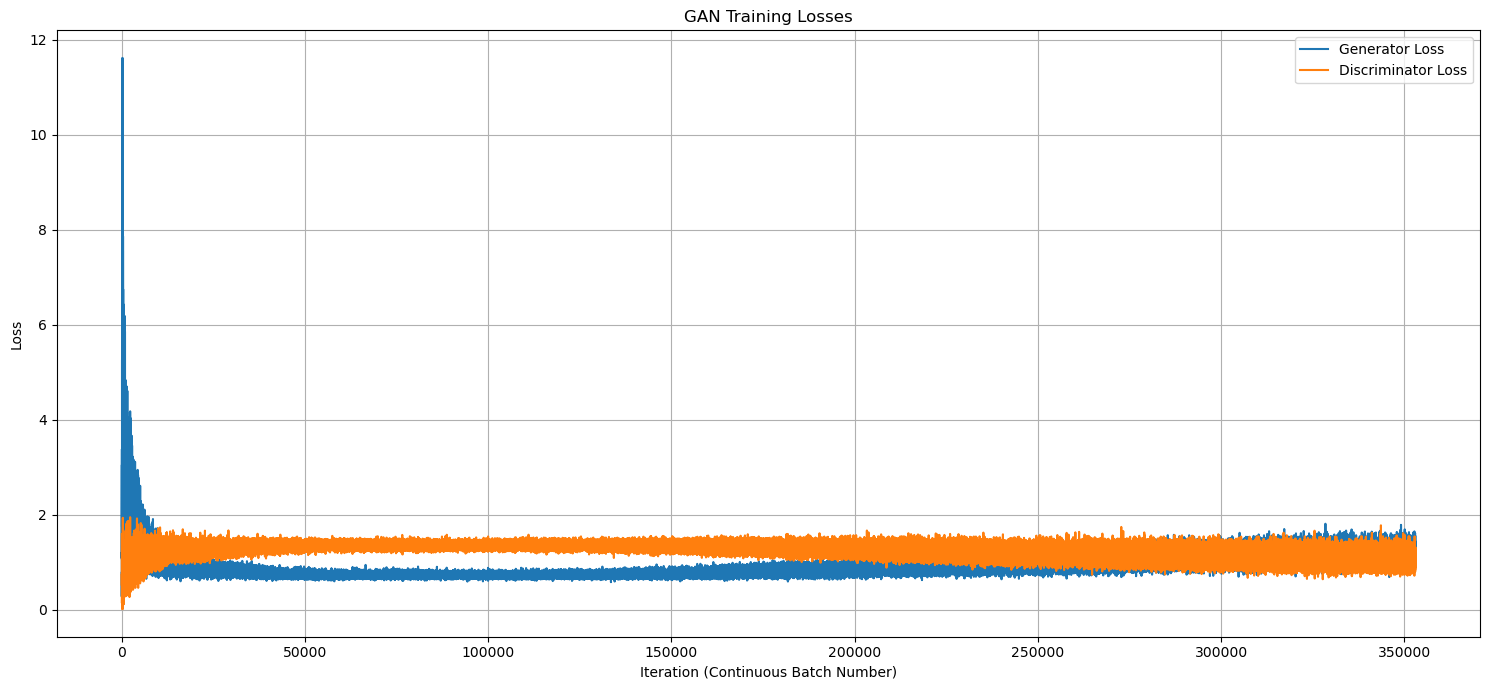

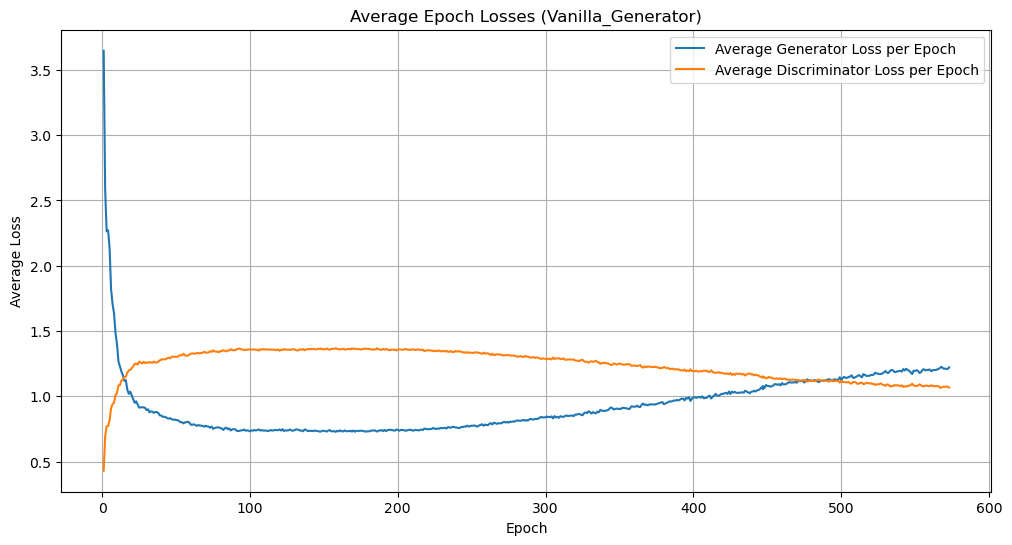


--- Generating and Plotting Images from H5 Models ---

Loading generator model: Vanilla_Generator_epoch_0001.h5
1/1 [==============================] - 0s 439ms/step


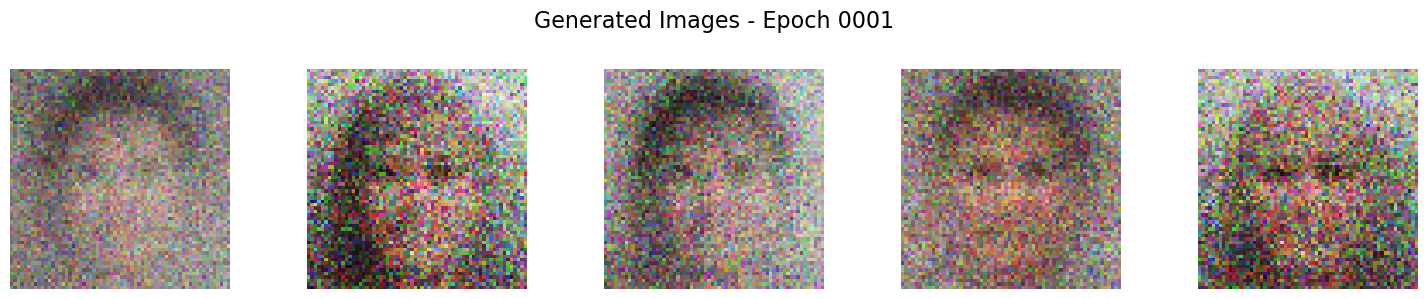


Loading generator model: Vanilla_Generator_epoch_0100.h5
1/1 [==============================] - 0s 209ms/step


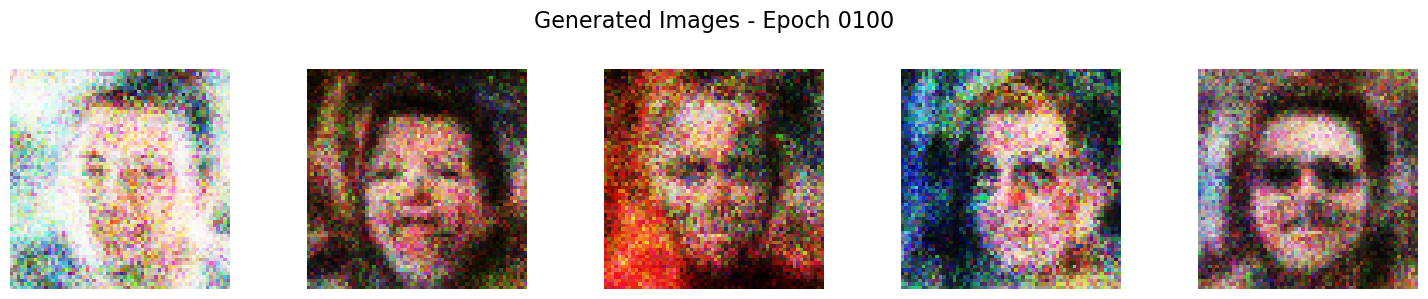


Loading generator model: Vanilla_Generator_epoch_0200.h5
1/1 [==============================] - 0s 160ms/step


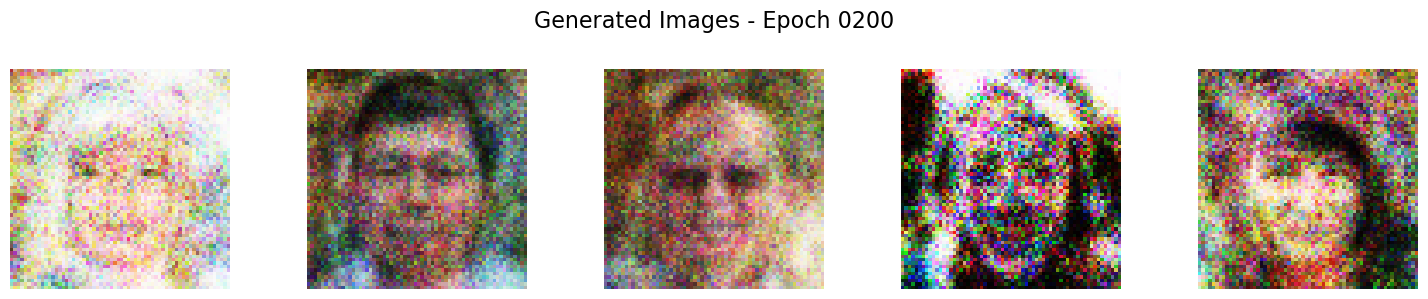


Loading generator model: Vanilla_Generator_epoch_0300.h5
1/1 [==============================] - 0s 153ms/step


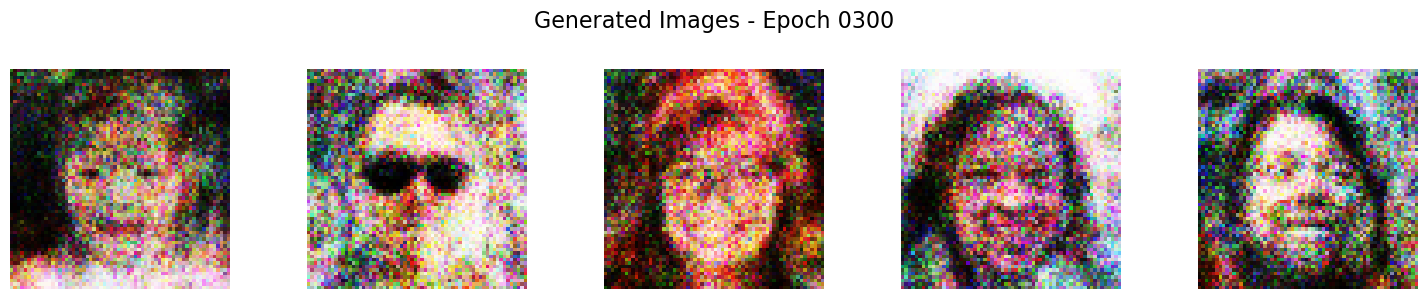


Loading generator model: Vanilla_Generator_epoch_0400.h5
1/1 [==============================] - 0s 142ms/step


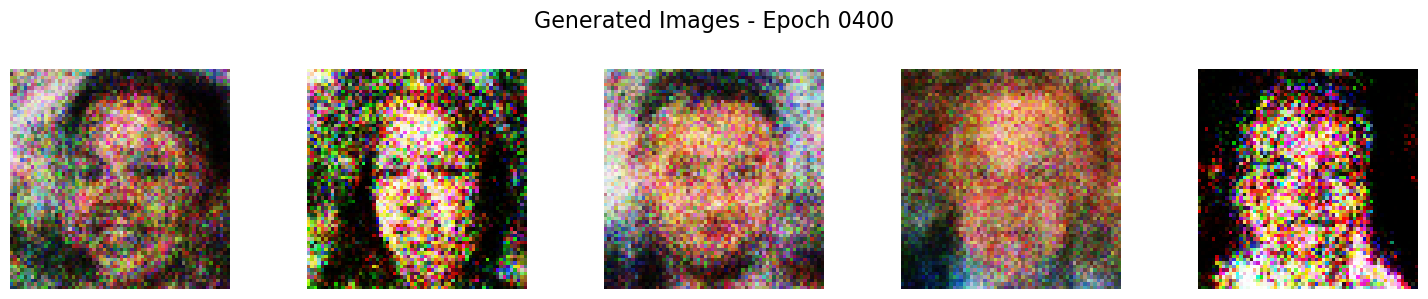


Loading generator model: Vanilla_Generator_epoch_0500.h5
1/1 [==============================] - 0s 172ms/step


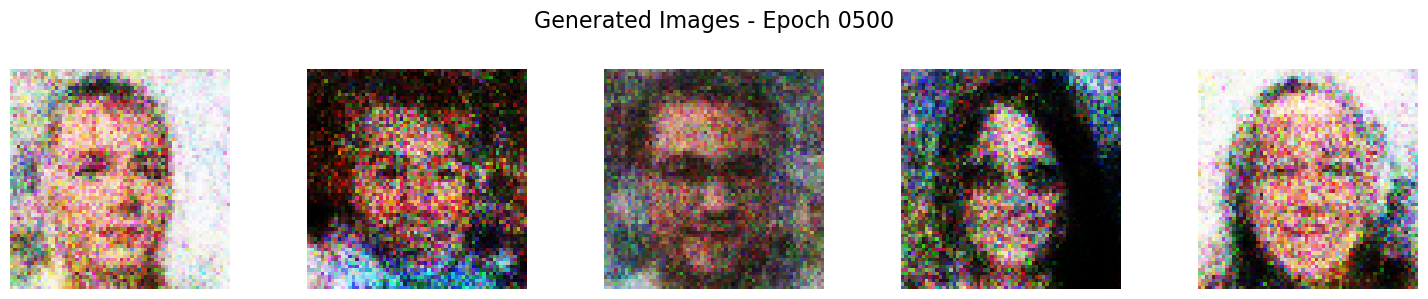


Loading generator model: Vanilla_Generator_epoch_0573.h5
1/1 [==============================] - 0s 147ms/step


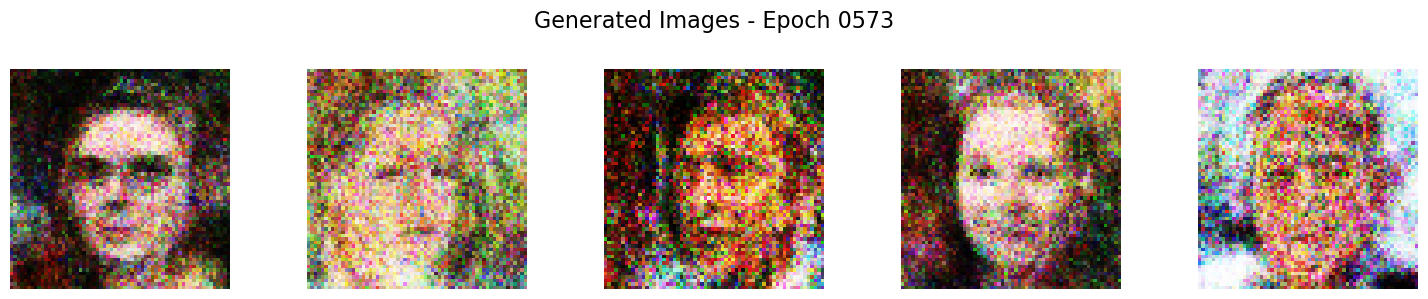


--- Script Finished ---


In [ ]:
print("\n--- Processing Loss CSVs ---")
combined_loss_df = load_and_combine_loss_csvs(FULL_DATA_PATH, MAX_EPOCHS_CSV, BATCHES_PER_EPOCH)
if combined_loss_df is not None:
    plot_losses(combined_loss_df)
else:
    print("Skipping loss plotting due to issues in loading CSV data.")


avg_loss_csv_path = os.path.join(vanilla_gan_sample_output_dir, "epoch_average_losses.csv")
epochs, avg_g_loss, avg_d_loss = [], [], []
with open(avg_loss_csv_path, 'r') as f:
    reader = csv.reader(f)
    next(reader) 
    for row in reader:
        epochs.append(int(row[0]))
        avg_g_loss.append(float(row[1]))
        avg_d_loss.append(float(row[2]))

plt.figure(figsize=(12, 6))
plt.plot(epochs, avg_g_loss, label='Average Generator Loss per Epoch')
plt.plot(epochs, avg_d_loss, label='Average Discriminator Loss per Epoch')
plt.title(f'Average Epoch Losses ({vanilla_gan.generator.name})')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(vanilla_gan_sample_output_dir, "average_epoch_loss_plot.png"))
plt.show()


print("\n--- Generating and Plotting Images from H5 Models ---")
for epoch in EPOCHS_TO_PLOT_IMAGES:
    model_filename = f"Vanilla_Generator_epoch_{epoch:04d}.h5"
    model_filepath = os.path.join(FULL_DATA_PATH, model_filename)

    if os.path.exists(model_filepath):
        print(f"\nLoading generator model: {model_filename}")
        generator = tf.keras.models.load_model(model_filepath)
        plot_generated_images(epoch, generator, NUM_IMAGES_TO_SHOW, NOISE_DIM)
    else:
        print(f"Generator model not found: {model_filename}")

print("\n--- Script Finished ---")

### Summary

In an ideal GAN training scenario, both losses would ideally converge to a stable equilibrium where the generator produces highly realistic samples, and the discriminator is at chance (e.g., loss around 0.693). This plot shows some characteristics of learning, but not a stable convergence.

It shows at the later phase epoch 300 onwarxs, the generator loss after reachign its minimum starts growing/ increasing. Meanawhile the discriminatro loss starts to slowly decrease.

Indicating here a mode collapse, where the generator started very producing a very limited variety of samples, if i trained it more the generated images will slowly epoch by epoch not showing any variety.

Even though, the learning rate generator is higher than discriminator, in the late stage the discriminator is overpowering the generator. Which shows the training instability

Thats why our model doesnt show any convergence.

By examine each of the sample generated image every 50 iteration we can see that the generator produce better and better image by showing less noise and also its shows a variety of diffrent images each stage of generated epoch. But if we look after the epoch 300 onwards the image doesn't produce any better noise so indicating the discriminatro overpowering the generator.

## FID Score

In [ ]:
BASE_PROJECT_PATH = r"C:\Users\Lenovo\Documents\Projects\smester 4\DL\AOL\vanilla_gan\gan_tf_vanilla_checkpoints"
DATA_SUBDIR = "h5_models_make_vanilla_generator_model"
FULL_MODEL_PATH_BASE = os.path.join(BASE_PROJECT_PATH, DATA_SUBDIR)

REAL_IMAGES_PATH = "real_sampled/"
TARGET_EPOCHS = [1, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 573]
NOISE_DIM = 100

IMG_WIDTH = 299
IMG_HEIGHT = 299
CHANNELS = 3
BATCH_SIZE_FID = 32

inception_model = InceptionV3(include_top=False,
                                pooling='avg',
                                input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS),
                                weights='imagenet')
print("InceptionV3 model loaded for feature extraction.")

InceptionV3 model loaded for feature extraction.


In [ ]:
inception_model = InceptionV3(include_top=False,
                                pooling='avg',
                                input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS),
                                weights='imagenet')
print("InceptionV3 model loaded for feature extraction.")

def get_embeddings(image_source, model, batch_size, is_file_paths=False):
    """
    Calculates embeddings for images using the provided model.
    Processes images in batches to save memory.

    Args:
        image_source: Either a list of image file paths (if is_file_paths=True)
                      or a NumPy array of image data (if is_file_paths=False).
        model: The InceptionV3 model for feature extraction.
        batch_size: Number of images to process in each batch.
        is_file_paths: Boolean, True if image_source is a list of paths, False otherwise.
    """
    all_embeddings = []
    num_images = len(image_source) if is_file_paths else image_source.shape[0]

    for i in range(0, num_images, batch_size):
        if is_file_paths:
            current_batch_paths = image_source[i:i + batch_size]
            batch_images_list = []
            for img_path in current_batch_paths:
                try:
                    img = Image.open(img_path).convert('RGB')
                    img_array = np.array(img, dtype=np.float32)
                    img_array_normalized = img_array / 255.0
                    batch_images_list.append(img_array_normalized)
                except Exception as e:
                    print(f"Warning: Could not load or process image {img_path} in batch: {e}")
                    continue
            if not batch_images_list:
                continue
            batch_images_np = np.array(batch_images_list, dtype=np.float32)
        else:
        
            batch_images_np = image_source[i:i + batch_size].astype(np.float32)

        if batch_images_np.ndim == 3:
            batch_images_np = np.expand_dims(batch_images_np, axis=0)
        if batch_images_np.shape[0] == 0:
            continue

    
        batch_images_tf = tf.convert_to_tensor(batch_images_np, dtype=tf.float32)
        resized_batch_tf = tf.image.resize(batch_images_tf,
                                           [IMG_HEIGHT, IMG_WIDTH],
                                           method=tf.image.ResizeMethod.BILINEAR,
                                           antialias=True)
        resized_batch_np = resized_batch_tf.numpy()

    
    
        if resized_batch_np.min() < -0.1:
            resized_batch_0_1 = (resized_batch_np + 1.0) / 2.0
        else:
             resized_batch_0_1 = np.clip(resized_batch_np, 0.0, 1.0)

        images_for_inception = resized_batch_0_1 * 255.0
        preprocessed_batch = preprocess_input(images_for_inception)

        batch_embeddings = model.predict(preprocessed_batch, verbose=0)
        all_embeddings.append(batch_embeddings)

    if not all_embeddings:
        print("Warning: No embeddings were generated. Check image loading and processing.")
        return np.array([])

    return np.concatenate(all_embeddings, axis=0)

def calculate_fid(act1, act2):
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2.0)
    epsilon = 1e-6

    sigma1_stable = sigma1 + np.eye(sigma1.shape[0]) * epsilon
    sigma2_stable = sigma2 + np.eye(sigma2.shape[0]) * epsilon
    covmean, _ = sqrtm(sigma1_stable.dot(sigma2_stable), disp=False)

    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

def get_real_image_filepaths(image_dir, num_images_to_use=None):
    print(f"Scanning for real image file paths in: {image_dir}")
    real_image_paths = []

    if not os.path.exists(image_dir):
        print(f"ERROR: Real images directory not found: {image_dir}")
        return []
    if not os.listdir(image_dir):
        print(f"ERROR: No files found in real images directory: {image_dir}")
        return []

    for img_file in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_file)
        if os.path.isfile(img_path) and img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            real_image_paths.append(img_path)

    if not real_image_paths:
        print("ERROR: No valid image files found in the directory.")
        return []
    else:
        print(f"Found {len(real_image_paths)} real image files in total.")
        if num_images_to_use is not None and 0 < num_images_to_use < len(real_image_paths):
            print(f"Selecting a random subset of {num_images_to_use} real images.")
            random.shuffle(real_image_paths)
            selected_paths = real_image_paths[:num_images_to_use]
            print(f"Using {len(selected_paths)} images for FID.")
            return selected_paths
        elif num_images_to_use is not None and num_images_to_use >= len(real_image_paths):
            print(f"Requested {num_images_to_use} images, but only {len(real_image_paths)} available. Using all available.")
            return real_image_paths
        else:
            print(f"Using all {len(real_image_paths)} available real images.")
            return real_image_paths

InceptionV3 model loaded for feature extraction.


In [ ]:

if __name__ == "__main__":
    
    NUM_IMAGES_FOR_FID = 1000  
    real_image_paths_list = get_real_image_filepaths(REAL_IMAGES_PATH, num_images_to_use=NUM_IMAGES_FOR_FID)

    if not real_image_paths_list:
        print("Halting FID calculation as no real image file paths were found.")
    else:
        
        print(f"\nCalculating embeddings for {len(real_image_paths_list)} real images (processing in batches)...")
        real_embeddings = get_embeddings(real_image_paths_list, inception_model, BATCH_SIZE_FID, is_file_paths=True)

        if real_embeddings.shape[0] == 0:
            print("Halting FID calculation as no embeddings could be generated for real images.")
        else:
            print(f"Real image embeddings shape: {real_embeddings.shape}")
            fid_scores = {}

            for epoch in TARGET_EPOCHS:
                generator_model_name = f"Vanilla_Generator_epoch_{epoch:04d}.h5"
                generator_model_path = os.path.join(FULL_MODEL_PATH_BASE, generator_model_name)

                if not os.path.exists(generator_model_path):
                    print(f"\nGenerator model for epoch {epoch} not found at {generator_model_path}. Skipping.")
                    continue

                print(f"\n--- Processing Epoch {epoch} ---")
                print(f"Loading generator: {generator_model_path}")
                try:
                    generator = load_model(generator_model_path, compile=False)
                except Exception as e:
                    print(f"Error loading generator for epoch {epoch}: {e}")
                    continue

                num_generated_images = len(real_image_paths_list)
                
                print(f"Generating {num_generated_images} images for epoch {epoch}...")
                noise = np.random.normal(0, 1, (num_generated_images, NOISE_DIM)).astype(np.float32)
                generated_images_raw = generator.predict(noise, batch_size=BATCH_SIZE_FID, verbose=0) 
                
                generated_images_raw = generated_images_raw.astype(np.float32)


                print(f"Generated {generated_images_raw.shape[0]} images.")
                if generated_images_raw.shape[0] > 0:
                     print(f"Shape of first generated image: {generated_images_raw[0].shape}, Min: {generated_images_raw[0].min():.2f}, Max: {generated_images_raw[0].max():.2f}, Dtype: {generated_images_raw.dtype}")


                
                print(f"Calculating embeddings for generated images (epoch {epoch})...")
                generated_embeddings = get_embeddings(generated_images_raw, inception_model, BATCH_SIZE_FID, is_file_paths=False)

                if generated_embeddings.shape[0] == 0:
                    print(f"Skipping FID for epoch {epoch} as no embeddings generated for fake images.")
                    continue

                print(f"Generated image embeddings shape: {generated_embeddings.shape}")

                
                print(f"Calculating FID score for epoch {epoch}...")
                current_fid_score = calculate_fid(real_embeddings, generated_embeddings)
                fid_scores[epoch] = current_fid_score
                print(f"FID score for epoch {epoch}: {current_fid_score:.4f}")

            print("\n--- Summary of FID Scores ---")
            if fid_scores:
                for epoch_val, score in sorted(fid_scores.items()):
                    print(f"Epoch {epoch_val:04d}: FID = {score:.4f}")
            else:
                print("No FID scores were calculated.")

    print("\nFID calculation process finished.")

Scanning for real image file paths in: real_sampled/
Found 19696 real image files in total.
Selecting a random subset of 1000 real images.
Using 1000 images for FID.

Calculating embeddings for 1000 real images (processing in batches)...
Real image embeddings shape: (1000, 2048)

--- Processing Epoch 1 ---
Loading generator: C:\Users\Lenovo\Documents\Projects\smester 4\DL\AOL\vanilla_gan\gan_tf_vanilla_checkpoints\h5_models_make_vanilla_generator_model\Vanilla_Generator_epoch_0001.h5
Generating 1000 images for epoch 1...
Generated 1000 images.
Shape of first generated image: (64, 64, 3), Min: -0.92, Max: 0.95, Dtype: float32
Calculating embeddings for generated images (epoch 1)...
Generated image embeddings shape: (1000, 2048)
Calculating FID score for epoch 1...
FID score for epoch 1: 348.8032

--- Processing Epoch 50 ---
Loading generator: C:\Users\Lenovo\Documents\Projects\smester 4\DL\AOL\vanilla_gan\gan_tf_vanilla_checkpoints\h5_models_make_vanilla_generator_model\Vanilla_Generato

### Summary

If we recall the loss before, the gnereator loss plot showed the loss reaching its inimum around 200-300 epoch. However, the FID scores in that time fraome are significantly worese than the FID at epoch 50.

On the other hand teh images produce by generator epoch 50 are not that great either, its well blurry and have many noises. We must remember taht quantitative metrics like FID don't always perfectly align with human perception of nimage quality.

FID actually calculat es the distance between the distribution of features form real images and features form generated images. The features are extracted from a specific layer of a pre-trained InceptionV3 netwrok.

By all means, it looks at how similar the statistical properties of these features sets are, concidering both mean & covariance. Realism & diversity.

but why it have the better score of FID? If epoch 50 images look bad and this  the best FID, it implies that the images generated at later epochs (which had higher/worse FID scores) are even further from the real image distribution according to InceptionV3.

Well FID can be one of the metric for our training but from thsi expirience its better to use more than oen metrics. FID is not at wrong its just not correctly used on this case. So for our conclussion the loss & manual inspection is way better(maybe add FID just for extra features).

FID can help as a supporting metrics in our loss. It shows that the FID values are only showing consistenly in 200 - 300 vcalues meaning in this highly score still having a noticable diffrence interms of featrues, quality and diversity.

FID also shows confirmation of training instability: The fluctuating FID scores, especially when contrasted with the smoother (though eventually degrading) loss curves, highlight the inherent instability in GAN training.
